# WHATEVER YOU DO DONT RUN THE WHOLE NOTEBOOK !!!! API CALLS WILL BE GONE

The parts that chew up the API calls are near the very bottom, and labeled via comments. Feel free to run the notebook and check out the DataViz, Tables are NOT generated in this
notebook, instead use the exploratory_analysis notebook to export DF's to the folder the notebooks are in.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import datetime as dt
import requests
from collections import Counter
import pickle

import os
API_key = os.environ.get('WWO_API_key')

In [2]:
##### LOAD IN FROM HERE TO SAVE TIME (FILES CREATED IN EDA notebook)

df = pd.read_csv('flights1500.csv')


file_handler1 = open('flights_months.obj', 'rb')
months = pickle.load(file_handler1)

file_handler2 = open('flights_wmonths.obj', 'rb')
wmonths = pickle.load(file_handler2)

df2 = pd.read_csv('df2.csv')

file_handler3 = open('flights_fuel_months.obj', 'rb')
fuel_months_df = pickle.load(file_handler3)

In [3]:
df.dtypes

fl_date                 object
mkt_unique_carrier      object
branded_code_share      object
mkt_carrier             object
mkt_carrier_fl_num       int64
op_unique_carrier       object
tail_num                object
op_carrier_fl_num        int64
origin_airport_id        int64
origin                  object
origin_city_name        object
dest_airport_id          int64
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
cancelled              float64
cancellation_code      float64
diverted               float64
dup                     object
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
flights                float64
distance

In [4]:
df.isnull().sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                  0
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                  0
dep_delay                 0
taxi_out                  1
wheels_off                1
wheels_on                 1
taxi_in                   1
crs_arr_time              0
arr_time                  0
arr_delay                 0
cancelled                 0
cancellation_code      1481
diverted                  0
dup                       0
crs_elapsed_time          0
actual_elapsed_time       0
air_time                  1
flights                   0
distance                  0
carrier_delay          1204
weather_delay          1204
nas_delay           

In [5]:
df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'no_name'],
      dtype='object')

In [6]:
x = df['distance']
y = df['arr_delay']

Text(0, 0.5, 'Arrival delay (minutes)')

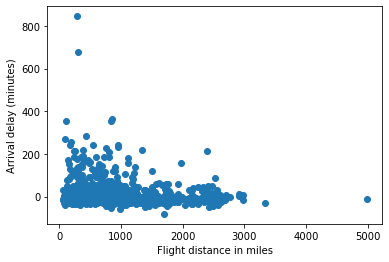

In [7]:
plt.scatter(x,y)
plt.xlabel('Flight distance in miles')
plt.ylabel('Arrival delay (minutes)')

In [8]:
df['mkt_carrier'].unique()

array(['B6', 'UA', 'AA', 'DL', 'WN', 'F9', 'HA', 'AS', 'NK', 'G4', 'VX'],
      dtype=object)

<AxesSubplot:xlabel='mkt_carrier', ylabel='arr_delay'>

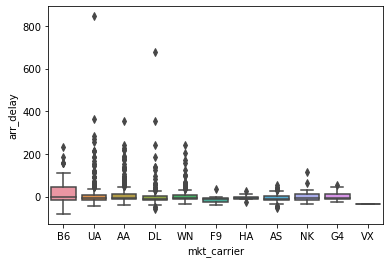

In [9]:
sns.boxplot(x='mkt_carrier', y="arr_delay", data=df)

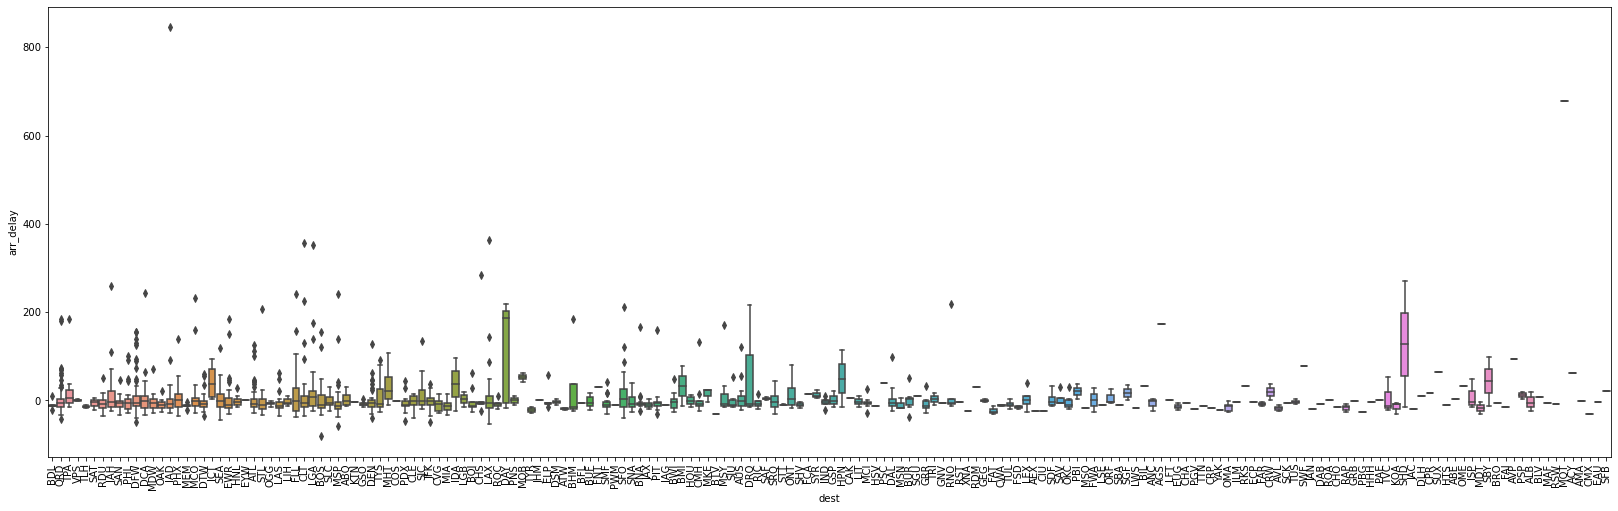

In [10]:
a4_dims = (28, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.boxplot(x='dest', y="arr_delay", data=df, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [11]:
df[['dep_time','crs_dep_time']]

,dep_time,crs_dep_time
0,1237.0,1234
1,718.0,730
2,1120.0,1125
3,1212.0,1215
4,1222.0,1220
...,...,...
1476,1827.0,1740
1477,2128.0,2132
1478,1848.0,1857
1479,1739.0,1709


In [12]:
# mkt_carrier
# origin
# dest
# dest_city_name
# distance
# flights
# carrier_delay
# weather_delay
# air_time
# fl_date

In [15]:
# Finds correct index for WWO json for the right 3 hour period, in order to find weather description

# parameters(time (h,m))   returns (index(int))
def decide_time(time):
    if time[:-2] == '':
        h = 0
    else:
        h = int(time[:-2])
    # try:
    m = int(time[-2:])
    # except:
    #     print("ERROR: m is", time[-2:], '!!!')
        
    if m > 30 & h != 23:  # averages the hour up using minutes, unless it rolls over to next day (past 2400)
        h+1
    if h >= 21:
        return 7
    elif h >= 18:
        return 6
    elif h >= 15:
        return 5
    elif h >= 12:
        return 4
    elif h >= 9:
        return 3
    elif h >= 6:
        return 2
    elif h >= 3:
        return 1
    else:
        return 0   # Probably the worst function I've ever wrote, don't know python well enough to make this concise (enumerate instead?)

In [16]:
airports = pd.read_csv('airports.csv')  # found a database of airports, so with airport IATA code i can get the lat,lon coords for the actual weather around that airport
                                        # not just the whole city. Link to the database: https://davidmegginson.github.io/ourairports-data/airports.csv
def get_latlon(row):                     
    
    IATA = row['origin']          
    latlon = airports[airports['iata_code']==IATA][['latitude_deg','longitude_deg']].values[0]

    return latlon

In [17]:
def get_weatherDesc(row):
    date, time = row['fl_date'], str(row['crs_dep_time'])
    lat,lon = get_latlon(row)
    time_cursor = decide_time(time)
    # print(date,time,lat,lon,time_cursor)
    url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=eedc910ff6464b568f6233003221603&q={lat},{lon}&date={date}&num_of_days=1&format=json"
    data = requests.get(url).json()

    weather = data['data']['weather'][0]['hourly'][time_cursor]['weatherDesc'][0]['value']
    return weather 

In [18]:
df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-05-15,B6,B6,B6,176,B6,N729JB,176,14843,SJU,...,1666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-24,UA,UA_CODESHARE,UA,5350,OO,N913SW,5350,10785,BTV,...,763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-13,UA,UA_CODESHARE,UA,4382,EV,N608UX,4382,11193,CVG,...,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-02,AA,AA,AA,1510,AA,N958AN,1510,13930,ORD,...,1012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-24,AA,AA_CODESHARE,AA,5740,YV,N249LR,5740,11298,DFW,...,641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,2019-06-20,WN,WN,WN,865,WN,N944WN,865,14908,SNA,...,404.0,8.0,0.0,0.0,0.0,34.0,NaN,NaN,NaN,NaN
1477,2019-06-13,DL,DL,DL,1953,DL,N978DL,1953,10397,ATL,...,743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1478,2018-03-04,AS,AS,AS,15,AS,N251AK,15,10721,BOS,...,2496.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479,2018-09-30,G4,G4,G4,2173,G4,883GA,2173,14259,PSM,...,1144.0,0.0,0.0,0.0,0.0,21.0,NaN,NaN,NaN,NaN


In [19]:
df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-05-15,B6,B6,B6,176,B6,N729JB,176,14843,SJU,...,1666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-24,UA,UA_CODESHARE,UA,5350,OO,N913SW,5350,10785,BTV,...,763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-13,UA,UA_CODESHARE,UA,4382,EV,N608UX,4382,11193,CVG,...,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-02,AA,AA,AA,1510,AA,N958AN,1510,13930,ORD,...,1012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-24,AA,AA_CODESHARE,AA,5740,YV,N249LR,5740,11298,DFW,...,641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,2019-06-20,WN,WN,WN,865,WN,N944WN,865,14908,SNA,...,404.0,8.0,0.0,0.0,0.0,34.0,NaN,NaN,NaN,NaN
1477,2019-06-13,DL,DL,DL,1953,DL,N978DL,1953,10397,ATL,...,743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1478,2018-03-04,AS,AS,AS,15,AS,N251AK,15,10721,BOS,...,2496.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479,2018-09-30,G4,G4,G4,2173,G4,883GA,2173,14259,PSM,...,1144.0,0.0,0.0,0.0,0.0,21.0,NaN,NaN,NaN,NaN


In [20]:
weather_df = df.copy()
weather_df.reset_index()
weather_df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-05-15,B6,B6,B6,176,B6,N729JB,176,14843,SJU,...,1666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-24,UA,UA_CODESHARE,UA,5350,OO,N913SW,5350,10785,BTV,...,763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-13,UA,UA_CODESHARE,UA,4382,EV,N608UX,4382,11193,CVG,...,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-02,AA,AA,AA,1510,AA,N958AN,1510,13930,ORD,...,1012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-24,AA,AA_CODESHARE,AA,5740,YV,N249LR,5740,11298,DFW,...,641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,2019-06-20,WN,WN,WN,865,WN,N944WN,865,14908,SNA,...,404.0,8.0,0.0,0.0,0.0,34.0,NaN,NaN,NaN,NaN
1477,2019-06-13,DL,DL,DL,1953,DL,N978DL,1953,10397,ATL,...,743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1478,2018-03-04,AS,AS,AS,15,AS,N251AK,15,10721,BOS,...,2496.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479,2018-09-30,G4,G4,G4,2173,G4,883GA,2173,14259,PSM,...,1144.0,0.0,0.0,0.0,0.0,21.0,NaN,NaN,NaN,NaN


In [43]:
#### WHATEVER YOU DO DON"T TOUCH THIS WE REALLY NEED THOSE API CALLS




for index, row in weather_df.iterrows():
        print('.', end='')
        weather_df.loc[index, 'dep_weather'] = get_weatherDesc(row)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [23]:
#### TEST THAT THE JSON IS CORRECTLY PARSED     DON"T TOUCH LOL WE NEED THOSE API CALLS

IATA = 'SJU'

date = '2019-05-15'
lat,lon = latlon = airports[airports['iata_code']==IATA][['latitude_deg','longitude_deg']].values[0]


url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=eedc910ff6464b568f6233003221603&q={lat},{lon}&date={date}&num_of_days=1&format=json"
data = requests.get(url).json()
data

{'data': {'request': [{'type': 'LatLon', 'query': 'Lat 18.44 and Lon -66.00'}],
  'weather': [{'date': '2019-05-15',
    'astronomy': [{'sunrise': '05:51 AM',
      'sunset': '06:50 PM',
      'moonrise': '03:56 PM',
      'moonset': '03:30 AM',
      'moon_phase': 'First Quarter',
      'moon_illumination': '74'}],
    'maxtempC': '29',
    'maxtempF': '85',
    'mintempC': '26',
    'mintempF': '78',
    'avgtempC': '28',
    'avgtempF': '83',
    'totalSnow_cm': '0.0',
    'sunHour': '13.0',
    'uvIndex': '7',
    'hourly': [{'time': '0',
      'tempC': '26',
      'tempF': '79',
      'windspeedMiles': '10',
      'windspeedKmph': '16',
      'winddirDegree': '127',
      'winddir16Point': 'SE',
      'weatherCode': '113',
      'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0008_clear_sky_night.png'}],
      'weatherDesc': [{'value': 'Clear'}],
      'precipMM': '0.0',
      'precipInches': '0.0',
      'humidity': '85',
      'vi

In [26]:





weather = data['data']['weather'][0]['hourly'][0]['weatherDesc'][time_cursor]['value']
weather

'Clear'

In [30]:
for index, row in df.head(1).iterrows():
    date, time = row['fl_date'], str(row['crs_dep_time'])
    
date,time

('2019-05-15', '1234')

In [31]:
time_cursor = decide_time(time)

In [32]:
time_cursor

4

In [37]:
data['data']['weather'][0]

{'date': '2019-05-15',
 'astronomy': [{'sunrise': '05:51 AM',
   'sunset': '06:50 PM',
   'moonrise': '03:56 PM',
   'moonset': '03:30 AM',
   'moon_phase': 'First Quarter',
   'moon_illumination': '74'}],
 'maxtempC': '29',
 'maxtempF': '85',
 'mintempC': '26',
 'mintempF': '78',
 'avgtempC': '28',
 'avgtempF': '83',
 'totalSnow_cm': '0.0',
 'sunHour': '13.0',
 'uvIndex': '7',
 'hourly': [{'time': '0',
   'tempC': '26',
   'tempF': '79',
   'windspeedMiles': '10',
   'windspeedKmph': '16',
   'winddirDegree': '127',
   'winddir16Point': 'SE',
   'weatherCode': '113',
   'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0008_clear_sky_night.png'}],
   'weatherDesc': [{'value': 'Clear'}],
   'precipMM': '0.0',
   'precipInches': '0.0',
   'humidity': '85',
   'visibility': '10',
   'visibilityMiles': '6',
   'pressure': '1015',
   'pressureInches': '30',
   'cloudcover': '11',
   'HeatIndexC': '29',
   'HeatIndexF': '84',
   'DewPointC': '2

In [21]:
weather_df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-05-15,B6,B6,B6,176,B6,N729JB,176,14843,SJU,...,1666.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-24,UA,UA_CODESHARE,UA,5350,OO,N913SW,5350,10785,BTV,...,763.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-13,UA,UA_CODESHARE,UA,4382,EV,N608UX,4382,11193,CVG,...,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-06-02,AA,AA,AA,1510,AA,N958AN,1510,13930,ORD,...,1012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-24,AA,AA_CODESHARE,AA,5740,YV,N249LR,5740,11298,DFW,...,641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,2019-06-20,WN,WN,WN,865,WN,N944WN,865,14908,SNA,...,404.0,8.0,0.0,0.0,0.0,34.0,NaN,NaN,NaN,NaN
1477,2019-06-13,DL,DL,DL,1953,DL,N978DL,1953,10397,ATL,...,743.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1478,2018-03-04,AS,AS,AS,15,AS,N251AK,15,10721,BOS,...,2496.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479,2018-09-30,G4,G4,G4,2173,G4,883GA,2173,14259,PSM,...,1144.0,0.0,0.0,0.0,0.0,21.0,NaN,NaN,NaN,NaN


In [46]:
###### SAVES ABOVE DATAFRAME FOR OTHER NOTEBOOKS, AND TO SAVE TIME


weather_df.to_csv('weatherframe.csv',index=False)

In [22]:
weather_df = pd.read_csv('weatherframe.csv')

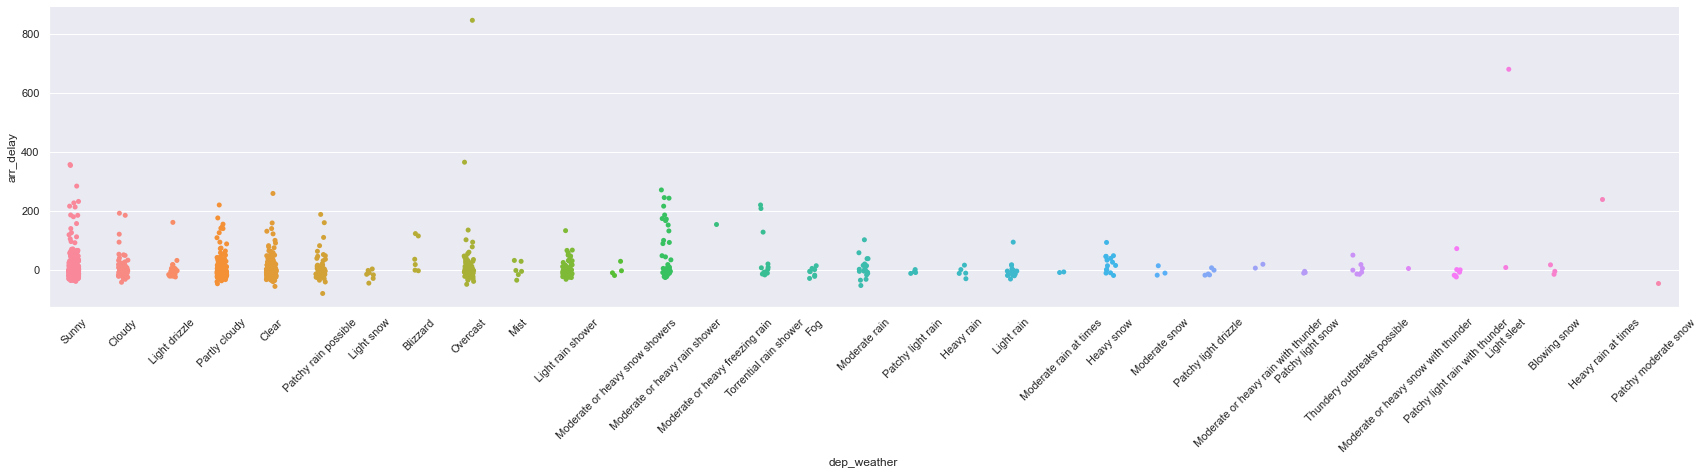

In [23]:

sns.set()
sns.catplot(x="dep_weather", y="arr_delay", data=weather_df, height=5, aspect=24/5)
plt.xticks(rotation=45)
plt.show()

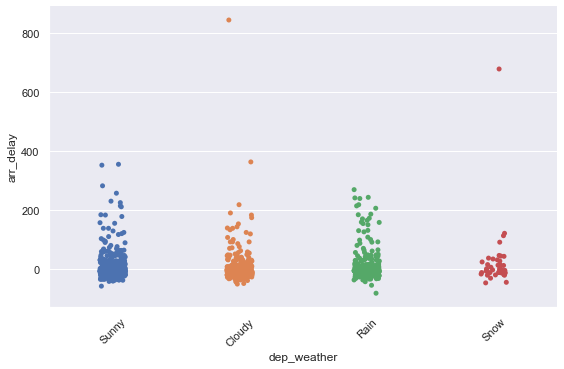

In [28]:
sns.set()
sns.catplot(x="dep_weather", y="arr_delay", data=weather_df, height=5, aspect=8/5)
plt.xticks(rotation=45)
plt.show()

In [ ]:
sunny, cloudy rain, snow

In [24]:
sunny = ['Clear']
cloudy = ['Partly cloudy','Overcast','Fog']
rain = ['Light drizzle','Patchy rain possible','Mist','Light rain shower','Moderate or heavy rain shower','Moderate or heavy freezing rain',
           'Torrential rain shower','Moderate rain','Patchy light rain','Heavy rain','Light rain','Moderate rain at times',
           'Patchy light drizzle','Moderate or heavy rain with thunder','Patchy light rain with thunder','Heavy rain at times','Thundery outbreaks possible']

snow = ['Light snow','Blizzard','Moderate or heavy snow showers','Heavy snow','Moderate snow','Patchy light snow','Moderate or heavy snow with thunder',
       'Light sleet','Blowing snow','Patchy moderate snow']



In [25]:
weather_df.loc[(weather_df.dep_weather.isin(sunny) ),'dep_weather']='Sunny'
weather_df.loc[(weather_df.dep_weather.isin(cloudy) ),'dep_weather']='Cloudy'
weather_df.loc[(weather_df.dep_weather.isin(rain) ),'dep_weather']='Rain'
weather_df.loc[(weather_df.dep_weather.isin(snow) ),'dep_weather']='Snow'

In [26]:
weather_df['dep_weather'].unique()

array(['Sunny', 'Cloudy', 'Rain', 'Snow'], dtype=object)

In [27]:
weather_df.to_csv('weatherframeTrunc.csv',index=False)

In [129]:
# TIME FOR SOME FUN

# mkt_carrier
# origin
# dest
# dest_city_name
# distance
# flights
# carrier_delay
# weather_delay
# air_time
# fl_date

In [78]:
X = weather_df[['mkt_carrier','distance','origin','dest','crs_dep_time','dep_weather']]
y = weather_df['arr_delay']

In [79]:
X = X.astype({'mkt_carrier': 'category', 'origin': 'category', 'dest': 'category', 'dep_weather': 'category' })

In [80]:
X.dtypes

mkt_carrier     category
distance         float64
origin          category
dest            category
crs_dep_time       int64
dep_weather     category
dtype: object

In [81]:
X['carrier_cat'] = X['mkt_carrier'].cat.codes
X['origin_cat'] = X['origin'].cat.codes
X['dest_cat'] = X['dest'].cat.codes
X = X.drop(['mkt_carrier','origin','dest','crs_dep_time','dep_weather'], axis=1)
X

,distance,carrier_cat,origin_cat,dest_cat
0,1666.0,2,179,13
1,763.0,8,23,124
2,264.0,8,44,124
3,1012.0,0,136,175
4,641.0,0,51,183
...,...,...,...,...
1476,404.0,10,183,166
1477,743.0,3,8,50
1478,2496.0,1,22,156
1479,1144.0,5,149,157


In [120]:
from sklearn.model_selection import train_test_split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [138]:
import xgboost as xgb

In [139]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [140]:
data_dmatrix = xgb.DMatrix(data=X,label=y, enable_categorical=True)

In [141]:
xg_reg.fit(X,y)

[21:08:17] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=12,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [142]:
y_pred = xg_reg.predict(X_test)

In [143]:
from sklearn.metrics import r2_score

In [144]:
r2_score(y_test, y_pred)

0.13150207942851744

In [133]:
data_dmatrix = xgb.DMatrix(data=X,label=y)